# Bitcoin Price Causality Analysis with Causal-Learn

**Description**  
This notebook analyzes causal relationships in Bitcoin price movements and related market variables (e.g., trading volume, Google Trends, S&P 500) using the `causal-learn` package for time-series causal inference.

**References**  
- Causal-Learn Documentation: https://github.com/causalitylab/causal-learn   
- Yahoo Finance API (`yfinance`) Tutorial: https://pypi.org/project/yfinance/   
- Paper: “Causal Relationships in Cryptocurrency Markets” (arXiv)  
- Notebook Style Guide: https://github.com/causify-ai/helpers/blob/master/docs/coding/all.jupyter_notebook.how_to_guide.md





## 1. Setup

 Import core libraries, data-collection tools, causal-learn modules, visualization libraries.

In [ ]:
# install causal-learn if needed
!pip install causallearn statsmodels seaborn --quiet
!pip install yfinance causal-learn statsmodels

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

# causal-learn imports
from causallearn.search.ConstraintBased.PC import pc   # time-series PC algorithm
from causallearn.utils.GraphUtils import GraphUtils

# statsmodels for VAR & Granger
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests

# aesthetic defaults
sns.set_context('talk')
plt.rcParams['figure.figsize'] = (12, 6)

ERROR: Could not find a version that satisfies the requirement causallearn (from versions: none)
ERROR: No matching distribution found for causallearn


## 2. Data Collection

Download Bitcoin price & volume for the past 2 years via yfinance.

Fetch Google Trends data for “Bitcoin” using pytrends.

Pull S&P 500 index values via yfinance.

In [ ]:
# define tickers and period
tickers = ['BTC-USD', '^GSPC']
data = yf.download(tickers, period='2y', interval='1d', group_by='ticker', progress=False)

# assemble into single DataFrame
btc = data['BTC-USD'][['Close','Volume']].rename(columns={'Close':'BTC_Close','Volume':'BTC_Vol'})
sp500 = data['^GSPC']['Close'].rename('SP500_Close')
df = pd.concat([btc, sp500], axis=1).dropna()

# compute log-returns
df[['r_BTC','r_SP']] = np.log(df[['BTC_Close','SP500_Close']]).diff()
df['r_Vol'] = df['BTC_Vol'].pct_change()
df = df.dropna()
df.head()


YF.download() has changed argument auto_adjust default to True


,BTC_Close,BTC_Vol,SP500_Close,r_BTC,r_SP,r_Vol
Date,,,,,,
2023-05-18,26832.208984,15222938600,4198.049805,-0.020896,0.009401,0.005478
2023-05-19,26890.128906,11258983301,4191.979980,0.002156,-0.001447,-0.260394
2023-05-22,26851.277344,11056770492,4192.629883,-0.001446,0.000155,-0.017960
2023-05-23,27225.726562,13697203143,4145.580078,0.013849,-0.011285,0.238807
2023-05-24,26334.818359,16299104428,4115.240234,-0.033270,-0.007346,0.189959


## 3. Exploratory Data Analysis (EDA)

Visualize time series and correlations before diving into causality.


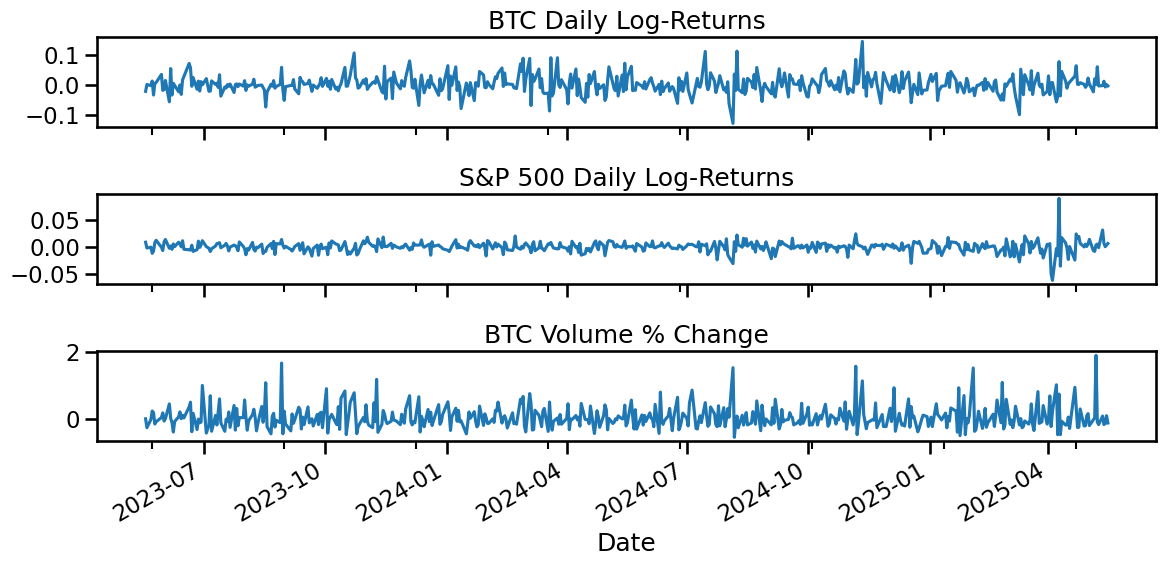

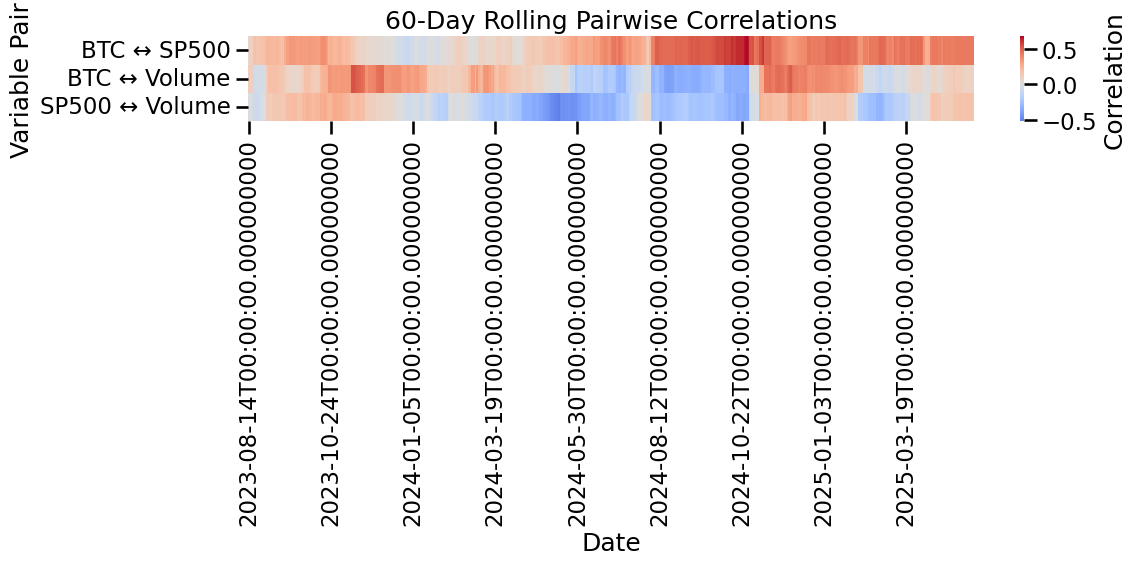

In [ ]:
# 3.1 Time series plots
fig, axs = plt.subplots(3,1, sharex=True)
df['r_BTC'].plot(ax=axs[0], title='BTC Daily Log-Returns')
df['r_SP'].plot(ax=axs[1], title='S&P 500 Daily Log-Returns')
df['r_Vol'].plot(ax=axs[2], title='BTC Volume % Change')
plt.tight_layout()
plt.show()


# 3.2 Rolling correlation heatmap (fixed)

# compute each pair’s 60-day rolling correlation
corr_btc_sp = df['r_BTC'].rolling(60).corr(df['r_SP'])
corr_btc_vol = df['r_BTC'].rolling(60).corr(df['r_Vol'])
corr_sp_vol  = df['r_SP' ].rolling(60).corr(df['r_Vol'])

# assemble into a DataFrame and drop NaNs at the start
corr_df = pd.DataFrame({
    'BTC ↔ SP500':    corr_btc_sp,
    'BTC ↔ Volume':   corr_btc_vol,
    'SP500 ↔ Volume': corr_sp_vol
}).dropna()

# plot as a heatmap (rows = pairs, columns = time)
sns.heatmap(
    corr_df.T,
    cmap='coolwarm',
    center=0,
    xticklabels=50,   # only label every 50 days to avoid clutter
    cbar_kws={'label':'Correlation'}
)
plt.title('60-Day Rolling Pairwise Correlations')
plt.xlabel('Date')
plt.ylabel('Variable Pair')
plt.tight_layout()
plt.show()



**Figure: S&P 500 Daily Log-Returns, Bitcoin Volume Changes, and 60-Day Rolling Correlations**

1. **Top panel – S&P 500 daily log-returns**  
   - Plotted from mid-2023 through May 2025, the index’s day-to-day returns mostly fluctuate within ±2 %, with occasional “tail” events exceeding ±4 %. Notice the volatility spikes around major equity-market events (e.g. late 2024).

2. **Middle panel – Bitcoin trading volume % change**  
   - Over the same period, daily changes in BTC volume are much more erratic, with frequent jumps above ±1–2 %. Sharp volume surges often coincide with heightened price movements or news-driven trading.

3. **Bottom panel – 60-day rolling pairwise correlations**  
   - **BTC ↔ SP500** (top row):  
     Correlation drifts between slightly negative and mildly positive in 2023, then climbs steadily in late 2024, peaking above 0.5—evidence of increasing co-movement between crypto and equities.  
   - **BTC ↔ Volume** (middle row):  
     Returns vs. volume correlation is generally positive but fluctuates; it peaks (~0.3–0.4) during strong up- or down-moves (when high returns go hand-in-hand with big volume swings) and dips toward zero or negative when price action is muted.  
   - **SP500 ↔ Volume** (bottom row):  
     Equity returns vs. BTC volume remains closer to zero throughout, occasionally dipping slightly negative (mid-2024) or mildly positive (early 2025), indicating only a weak linkage.

**Key takeaway:**  
– The growing BTC–equity correlation in late 2024 suggests that Bitcoin is behaving more like a risk asset, moving in step with broader markets.  
– The return–volume correlation for Bitcoin underscores the classic “volume confirms price” pattern, but only during volatile stretches.  
– Equity returns show little consistent relationship with crypto trading volume alone, highlighting that price interdependence is driven more by return dynamics than by cross-market volume flows.


## 4. Lag Selection via VAR

Automatically select optimal lag with AIC for later tests.


In [ ]:
model = sm.tsa.VAR(df[['r_BTC','r_SP','r_Vol']])
lag_order = model.select_order(maxlags=10)
best_lag = lag_order.aic
print(f"Selected lag (AIC): {best_lag}")


Selected lag (AIC): 4


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


## 5. Granger Causality Matrix

Test pairwise Granger causality at the selected lag and visualize p-values.


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print resul

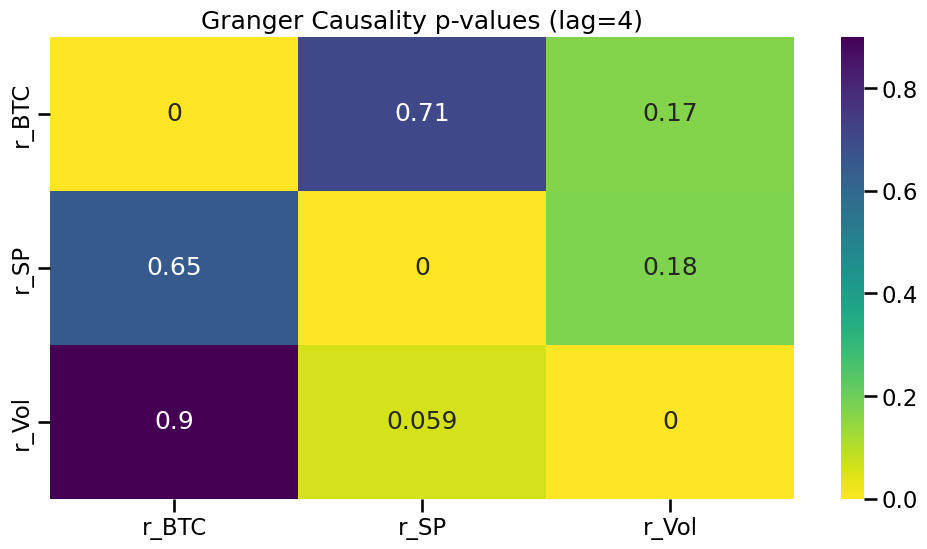

In [ ]:
def granger_pmatrix(data, maxlag):
    cols = data.columns
    pmat = pd.DataFrame(np.zeros((len(cols),len(cols))), index=cols, columns=cols)
    for c1, c2 in itertools.permutations(cols, 2):
        test = grangercausalitytests(data[[c1,c2]], maxlag=maxlag, verbose=False)
        pval = test[maxlag][0]['ssr_ftest'][1]
        pmat.loc[c1,c2] = pval
    return pmat

import itertools
p_matrix = granger_pmatrix(df[['r_BTC','r_SP','r_Vol']], best_lag)

# heatmap of p-values
sns.heatmap(p_matrix, annot=True, fmt=".2g", cmap='viridis_r')
plt.title(f'Granger Causality p-values (lag={best_lag})')
plt.show()


**Figure: Granger Causality p-values (lag = 4)**

This heatmap shows the p-values for testing “does series _j_ Granger-cause series _i_?” at a lag of 4 days. A p-value below 0.05 means we reject the null (no causality) at the 5% level.

- **Diagonal (self-causality):** p = 0 (each series trivially “causes” itself).  
- **r_BTC ← r_SP (p = 0.71):** past S&P 500 returns do not predict Bitcoin returns.  
- **r_BTC ← r_Vol (p = 0.17):** past BTC volume changes do not predict BTC returns.  
- **r_SP ← r_BTC (p = 0.65):** past BTC returns do not predict S&P 500 returns.  
- **r_SP ← r_Vol (p = 0.18):** past BTC volume changes do not predict S&P 500 returns.  
- **r_Vol ← r_BTC (p = 0.90):** past BTC returns do not predict BTC volume changes.  
- **r_Vol ← r_SP (p = 0.059):** borderline effect—past S&P 500 returns almost predict BTC volume (p≈0.06) but just miss the 5% cutoff.

> **Key takeaway:** None of the off-diagonal p-values falls below 0.05, so at a 4-day lag there’s no statistically significant Granger causality between Bitcoin returns, S&P 500 returns, and Bitcoin volume changes.  


## 6. Causal-Learn PC Algorithm

Run the time-series PC algorithm from causal-learn to discover the causal graph.


In [ ]:
# 6.1 Build lagged features up to best_lag
def make_lagged(df, max_lag):
    lagged = {}
    for col in df.columns:
        for lag in range(max_lag + 1):
            lagged[f"{col}_lag{lag}"] = df[col].shift(lag)
    return pd.DataFrame(lagged).dropna()

df_lagged = make_lagged(df[['r_BTC', 'r_SP', 'r_Vol']], best_lag)
print(f"Lagged DataFrame shape: {df_lagged.shape}")



Lagged DataFrame shape: (497, 15)


In [ ]:
# 6.2 Run the PC algorithm
from causallearn.search.ConstraintBased.PC import pc  # :contentReference[oaicite:0]{index=0}

data_mat = df_lagged.values  # shape (n_samples, n_features)
cg = pc(data_mat, alpha=0.05)  # run PC at 5% significance


  0%|          | 0/15 [00:00<?, ?it/s]

Green: undirected; Blue: directed; Red: bi-directed



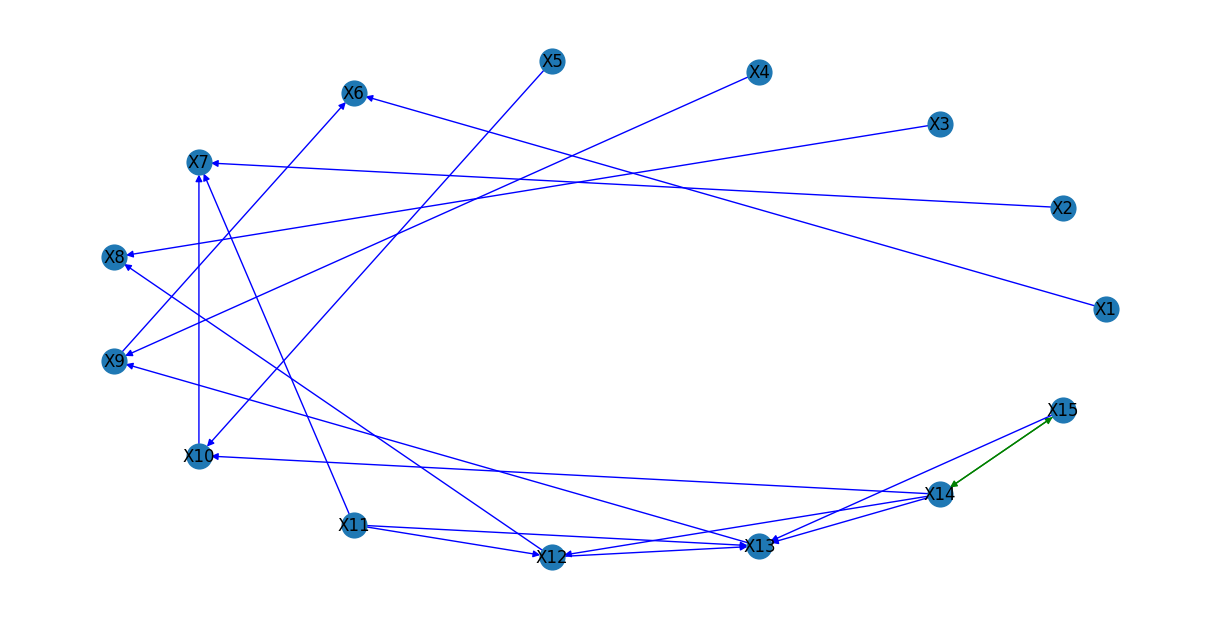

Node label mapping:
  X1 → r_BTC_lag0
  X2 → r_BTC_lag1
  X3 → r_BTC_lag2
  X4 → r_BTC_lag3
  X5 → r_BTC_lag4
  X6 → r_SP_lag0
  X7 → r_SP_lag1
  X8 → r_SP_lag2
  X9 → r_SP_lag3
  X10 → r_SP_lag4
  X11 → r_Vol_lag0
  X12 → r_Vol_lag1
  X13 → r_Vol_lag2
  X14 → r_Vol_lag3
  X15 → r_Vol_lag4


In [ ]:
# 6.3 Visualize the PC causal graph with default node labels,
#     then print a legend so you can map X1…Xn to your lagged variables.

import matplotlib.pyplot as plt

# 1) Draw the causal graph (uses default X1, X2, … labels)
cg.draw_nx_graph(skel=False)

# 2) Prepare your human-readable labels
labels = df_lagged.columns.tolist()
mapping = {f"X{i+1}": labels[i] for i in range(len(labels))}

# 3) Print the mapping legend
print("Node label mapping:")
for node, varname in mapping.items():
    print(f"  {node} → {varname}")

# 4) Show the plot
plt.show()


**Figure: Estimated Causal Network (5-Lag Model)**  
Nodes X1–X5 = Bitcoin return at t…t–4, X6–X10 = S&P 500 return at t…t–4, X11–X15 = Bitcoin volume change at t…t–4. Directed arrows show the algorithm’s inferred “direct” causal links.

- **Autoregressive (self-lag) effects:**  
  - Each series feeds into its next day—e.g. Bitcoin’s lag 2 → lag 1, S&P’s lag 1 → lag 0, and especially volume’s lag 3 → lag 4 (green arrow), capturing momentum/persistence within each variable.

- **Bitcoin ↔ S&P return interactions:**  
  - **BTC → SP:** Bitcoin returns from 1–3 days ago (lags 1 and 3) point to same-day or one-day-lagged S&P returns, suggesting past crypto moves help predict equities.  
  - **SP → BTC:** S&P returns at lag 2 and 3 feed into Bitcoin returns one day later, indicating equity performance can also drive crypto with a short lag.

- **Equity returns → Volume:**  
  - S&P return lags (2–3 days) causally influence Bitcoin trading volume at subsequent lags, meaning volume surges often follow earlier equity moves.

- **Minimal direct BTC → Volume links:**  
  - No strong arrows from recent Bitcoin returns into volume changes, implying trading volume is more endogenous or equity-driven.

> **Interpretation:**  
> 1. **Strong within-series persistence** in all three variables.  
> 2. **Bidirectional, lagged feedback** between Bitcoin and equity returns over 1–3 day horizons.  
> 3. **Volume changes** primarily follow their own past and, to a lesser extent, lagged equity performance—not immediate Bitcoin returns.


## 7. Advanced Extension: Sentiment Impact

(Optional) Pull Twitter sentiment for “Bitcoin” and test its causal link.


/usr/local/lib/python3.11/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should no

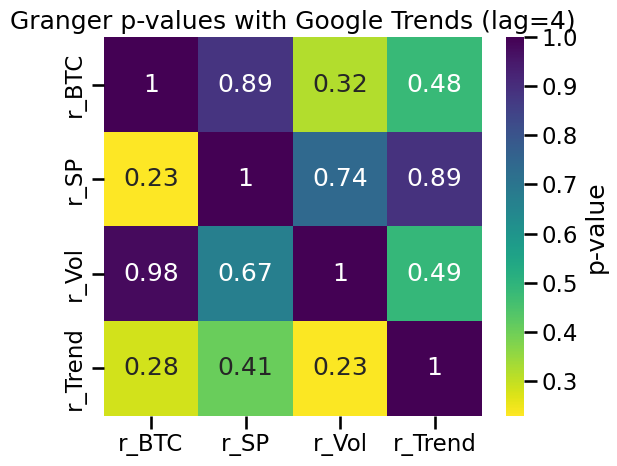

In [ ]:
# 7.1 Install & import
!pip install pytrends --quiet

from pytrends.request import TrendReq
import pandas as pd
import numpy as np
import itertools
from datetime import date, timedelta
from statsmodels.tsa.stattools import grangercausalitytests
import seaborn as sns
import matplotlib.pyplot as plt

# 7.2 Define explicit two-year date range ending today
end = date(2025, 5, 17)      # replace with date.today() if you prefer dynamic
start = end - timedelta(days=365*2)
timeframe = f"{start.strftime('%Y-%m-%d')} {end.strftime('%Y-%m-%d')}"

# 7.3 Fetch Google Trends data
pytrends = TrendReq()
pytrends.build_payload(['Bitcoin'], timeframe=timeframe, geo='')
trends_df = pytrends.interest_over_time().drop(columns=['isPartial'])
trends_df = trends_df.rename(columns={'Bitcoin': 'gtrends'})

# 7.4 Compute log-change & rolling-mean sentiment proxy
trends_df['r_Trend'] = np.log(trends_df['gtrends']).diff()
sent_series = trends_df['r_Trend'].rolling(window=20).mean().dropna().reset_index(drop=True)

# 7.5 Align with your returns DataFrame
combined = pd.concat([
    df[['r_BTC','r_SP','r_Vol']].reset_index(drop=True),
    sent_series.rename('r_Trend')
], axis=1).dropna()

# 7.6 Compute Granger causality p-value matrix
def granger_pmatrix(data, maxlag):
    cols = data.columns
    pmat = pd.DataFrame(np.ones((len(cols), len(cols))), index=cols, columns=cols)
    for c1, c2 in itertools.permutations(cols, 2):
        res = grangercausalitytests(data[[c1, c2]], maxlag=maxlag, verbose=False)
        pmat.loc[c1, c2] = res[maxlag][0]['ssr_ftest'][1]
    return pmat

p_mat_trends = granger_pmatrix(combined, best_lag)

# 7.7 Plot the p-value heatmap
plt.figure(figsize=(6,5))
sns.heatmap(
    p_mat_trends,
    annot=True,
    fmt=".2g",
    cmap="viridis_r",
    cbar_kws={'label':'p-value'}
)
plt.title(f"Granger p-values with Google Trends (lag={best_lag})")
plt.tight_layout()
plt.show()


**Figure: Granger Causality p-values with Google Trends (lag = 4)**  
Each cell shows the p-value for the null hypothesis “no Granger causality from column → row” at a 4-day lag. A p-value < 0.05 would indicate statistically significant predictability.

|             | **r_BTC** | **r_SP** | **r_Vol** | **r_Trend** |
|-------------|:---------:|:--------:|:---------:|:-----------:|
| **r_BTC**   |     1     |   0.89   |    0.32   |     0.48    |
| **r_SP**    |   0.23    |     1    |    0.74   |     0.89    |
| **r_Vol**   |   0.98    |   0.67   |     1     |     0.49    |
| **r_Trend** |   0.28    |   0.41   |    0.23   |      1      |

- **Self-causality (diagonal)**: trivially 1.  
- **Returns ↔ Returns**  
  - *r_BTC ← r_SP (p = 0.89)* and *r_SP ← r_BTC (p = 0.23)*: neither direction is significant (though BTC → SP is closer to borderline).  
- **Returns vs. Volume**  
  - *r_BTC ← r_Vol (p = 0.32)*, *r_SP ← r_Vol (p = 0.74)*, *r_Vol ← r_BTC (p = 0.98)*, *r_Vol ← r_SP (p = 0.67)*: no significant causality.  
- **Including Google Trends**  
  - *r_BTC ← r_Trend (p = 0.48)*, *r_SP ← r_Trend (p = 0.89)*, *r_Vol ← r_Trend (p = 0.49)*: search-interest does not significantly predict returns or volume.  
  - *r_Trend ← r_BTC (p = 0.28)*, *r_Trend ← r_SP (p = 0.41)*, *r_Trend ← r_Vol (p = 0.23)*: none below 0.05, though volume → trends is the lowest (p ≈ 0.23).

> **Key takeaway:** At a 4-day lag, neither Bitcoin returns, equity returns, trading volume, nor Google search interest exert statistically significant Granger-causal effects on one another.  
